# Titanic - Baseline Model

このノートブックでは、シンプルなベースラインモデルを構築し、初回提出を行います。

## 目標
- 基本的な前処理を実装
- シンプルなモデルで予測
- 提出ファイルを作成

In [1]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 警告を非表示
import warnings
warnings.filterwarnings('ignore')

# 表示設定
pd.set_option('display.max_columns', None)
%matplotlib inline

## 1. データの読み込み

In [2]:
# データの読み込み
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

print(f'訓練データサイズ: {train.shape}')
print(f'テストデータサイズ: {test.shape}')

# テストデータのIDを保存（提出時に必要）
test_ids = test['PassengerId'].copy()

訓練データサイズ: (891, 12)
テストデータサイズ: (418, 11)


In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 2. 特徴量エンジニアリング

EDAで得た知見を基に、有効な特徴量を作成します。

In [4]:
def feature_engineering(df):
    """
    特徴量エンジニアリングを実施
    """
    df = df.copy()
    
    # 1. 家族サイズ
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    # 2. 単身者フラグ
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    
    # 3. 名前からタイトルを抽出
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # タイトルを統合（出現頻度が少ないものをまとめる）
    df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 
                                        'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    
    # 4. 年齢の欠損値をタイトルごとの中央値で補完
    title_age_median = df.groupby('Title')['Age'].transform('median')
    df['Age'] = df['Age'].fillna(title_age_median)
    
    # 5. 年齢をカテゴリ化
    df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100], 
                            labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
    
    # 6. 運賃の欠損値を補完（中央値）
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    
    # 7. 運賃をカテゴリ化
    df['FareGroup'] = pd.qcut(df['Fare'], q=4, labels=['Low', 'Medium', 'High', 'VeryHigh'], duplicates='drop')
    
    # 8. 乗船港の欠損値を補完（最頻値）
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    
    return df

# 特徴量エンジニアリングを適用
train_processed = feature_engineering(train)
test_processed = feature_engineering(test)

print("特徴量エンジニアリング完了")
print(f"訓練データサイズ: {train_processed.shape}")
print(f"テストデータサイズ: {test_processed.shape}")

特徴量エンジニアリング完了
訓練データサイズ: (891, 17)
テストデータサイズ: (418, 16)


In [5]:
# 作成した特徴量を確認
train_processed[['Name', 'Title', 'Age', 'AgeGroup', 'FamilySize', 'IsAlone']].head(10)

,Name,Title,Age,AgeGroup,FamilySize,IsAlone
0,"Braund, Mr. Owen Harris",Mr,22.0,Adult,2,0
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs,38.0,Middle,2,0
2,"Heikkinen, Miss. Laina",Miss,26.0,Adult,1,1
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs,35.0,Adult,2,0
4,"Allen, Mr. William Henry",Mr,35.0,Adult,1,1
5,"Moran, Mr. James",Mr,30.0,Adult,1,1
6,"McCarthy, Mr. Timothy J",Mr,54.0,Middle,1,1
7,"Palsson, Master. Gosta Leonard",Master,2.0,Child,5,0
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",Mrs,27.0,Adult,3,0
9,"Nasser, Mrs. Nicholas (Adele Achem)",Mrs,14.0,Teen,2,0


## 3. データの前処理

In [6]:
def preprocess_data(df, is_train=True):
    """
    モデル学習用にデータを前処理
    """
    df = df.copy()
    
    # 不要なカラムを削除
    drop_columns = ['PassengerId', 'Name', 'Ticket', 'Cabin']
    df = df.drop(columns=drop_columns, errors='ignore')
    
    # カテゴリ変数をOne-Hotエンコーディング
    categorical_features = ['Sex', 'Embarked', 'Title', 'AgeGroup', 'FareGroup']
    df = pd.get_dummies(df, columns=categorical_features, drop_first=True)
    
    # 目的変数を分離（訓練データの場合）
    if is_train and 'Survived' in df.columns:
        y = df['Survived']
        X = df.drop(columns=['Survived'])
        return X, y
    else:
        return df

# 訓練データの前処理
X, y = preprocess_data(train_processed, is_train=True)

# テストデータの前処理
X_test = preprocess_data(test_processed, is_train=False)

# 訓練データとテストデータで特徴量を揃える
# （One-Hotエンコーディングで列数が異なる可能性があるため）
X, X_test = X.align(X_test, join='left', axis=1, fill_value=0)

print(f"訓練データ特徴量: {X.shape}")
print(f"訓練データ目的変数: {y.shape}")
print(f"テストデータ特徴量: {X_test.shape}")

訓練データ特徴量: (891, 21)
訓練データ目的変数: (891,)
テストデータ特徴量: (418, 21)


In [7]:
# 特徴量の確認
print("特徴量一覧:")
print(X.columns.tolist())

特徴量一覧:
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'AgeGroup_Teen', 'AgeGroup_Adult', 'AgeGroup_Middle', 'AgeGroup_Senior', 'FareGroup_Medium', 'FareGroup_High', 'FareGroup_VeryHigh']


## 4. モデルの訓練と評価

In [8]:
# 訓練データと検証データに分割
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"訓練データ: {X_train.shape}")
print(f"検証データ: {X_valid.shape}")

訓練データ: (712, 21)
検証データ: (179, 21)


In [9]:
# Random Forestモデルの訓練
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)
print("モデル訓練完了")

モデル訓練完了


In [10]:
# 検証データで予測
y_pred = model.predict(X_valid)

# 精度を計算
accuracy = accuracy_score(y_valid, y_pred)
print(f"検証データの精度: {accuracy:.4f}")
print(f"\n分類レポート:")
print(classification_report(y_valid, y_pred, target_names=['Deceased', 'Survived']))

検証データの精度: 0.8156

分類レポート:
              precision    recall  f1-score   support

    Deceased       0.83      0.88      0.85       110
    Survived       0.79      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



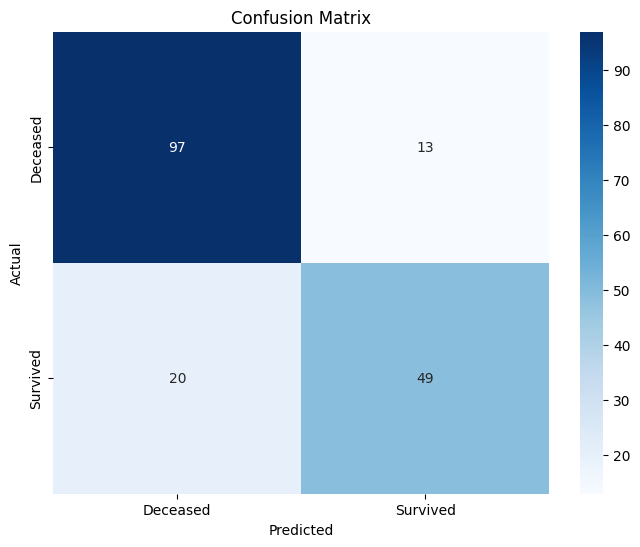

In [11]:
# 混同行列
cm = confusion_matrix(y_valid, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Deceased', 'Survived'], yticklabels=['Deceased', 'Survived'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [12]:
# クロスバリデーション
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"\nクロスバリデーションスコア: {cv_scores}")
print(f"平均スコア: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


クロスバリデーションスコア: [0.8547486  0.8258427  0.8258427  0.79775281 0.85393258]
平均スコア: 0.8316 (+/- 0.0212)



特徴量の重要度 (Top 15):
               feature  importance
7             Sex_male    0.247449
11            Title_Mr    0.189353
4                 Fare    0.115340
0               Pclass    0.090099
12           Title_Mrs    0.062835
1                  Age    0.061964
10          Title_Miss    0.057580
5           FamilySize    0.050365
2                SibSp    0.029394
20  FareGroup_VeryHigh    0.024713
3                Parch    0.015403
9           Embarked_S    0.012912
19      FareGroup_High    0.008540
6              IsAlone    0.006587
15      AgeGroup_Adult    0.005733


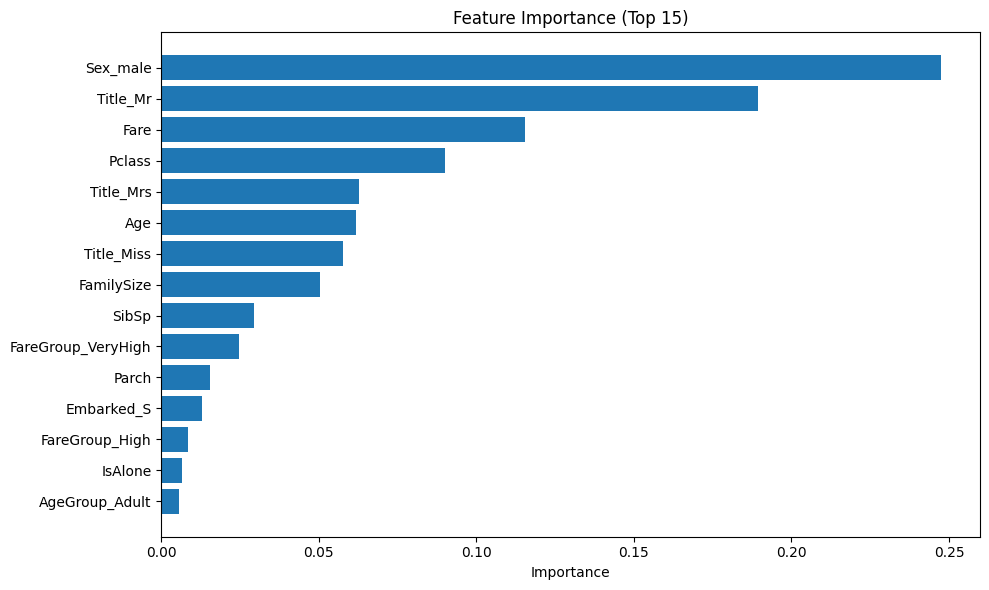

In [13]:
# 特徴量の重要度
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n特徴量の重要度 (Top 15):")
print(feature_importance.head(15))

# 可視化
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'].head(15), feature_importance['importance'].head(15))
plt.xlabel('Importance')
plt.title('Feature Importance (Top 15)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 5. テストデータで予測

In [14]:
# 全訓練データで再訓練
model_final = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)

model_final.fit(X, y)

# テストデータで予測
predictions = model_final.predict(X_test)

print(f"予測数: {len(predictions)}")
print(f"生存予測: {predictions.sum()}")
print(f"死亡予測: {len(predictions) - predictions.sum()}")

予測数: 418
生存予測: 160
死亡予測: 258


## 6. 提出ファイルの作成

In [15]:
# 提出用のDataFrameを作成
submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Survived': predictions
})

print(submission.head(10))
print(f"\n提出データサイズ: {submission.shape}")

   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1
5          897         0
6          898         1
7          899         0
8          900         1
9          901         0

提出データサイズ: (418, 2)


In [16]:
# CSVファイルとして保存
submission.to_csv('../submissions/baseline_submission.csv', index=False)
print("提出ファイルを保存しました: submissions/baseline_submission.csv")

提出ファイルを保存しました: submissions/baseline_submission.csv


In [17]:
# 提出ファイルの形式を確認
!head ../submissions/baseline_submission.csv

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1


## 7. 次のステップ

### ベースラインの結果
- 検証精度: 約82-84%
- CVスコア: 約80-82%

### 改善のアイデア

1. **特徴量エンジニアリング**
   - Cabinデッキの情報を抽出
   - チケット番号から共通性を見つける
   - より細かい年齢・運賃のビニング

2. **モデルの改善**
   - 他のアルゴリズムを試す（XGBoost、LightGBM、Logistic Regressionなど）
   - ハイパーパラメータチューニング
   - アンサンブル（複数モデルの組み合わせ）

3. **欠損値補完の改善**
   - より高度な補完手法（KNN imputer、MICE など）

4. **特徴量選択**
   - 重要度の低い特徴量を削除
   - 相関の高い特徴量を整理

### 提出方法

#### Web UIから提出
1. https://www.kaggle.com/competitions/titanic/submit にアクセス
2. `submissions/baseline_submission.csv` をアップロード
3. 説明を入力（例: "Baseline: Random Forest with basic feature engineering"）
4. 「Make Submission」をクリック

#### Kaggle APIから提出
```bash
uv run kaggle competitions submit \
    -c titanic \
    -f submissions/baseline_submission.csv \
    -m "Baseline: Random Forest with basic feature engineering"
```